<a href="https://colab.research.google.com/github/Jepees/NLP-with-Disaster-Tweets/blob/main/using_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import string
import nltk
import time
import re
import os

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, pos_tag
from scipy.sparse import hstack
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

np.random.seed(1611)
plt.style.use('default')    # Reset style matplotlib
plt.rcdefaults()            # Reset rcParams ke default
sns.reset_defaults()        # Reset style seaborn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [2]:
df_train = pd.read_csv("http://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/Jepees/NLP-with-Disaster-Tweets/refs/heads/main/Dataset/test.csv")

print(f"total data train: {df_train.shape[0]}\ntotal data test : {df_test.shape[0]}")

total data train: 7613
total data test : 3263


## Exploratory Data

In [3]:
df_train.sample(5)

,id,keyword,location,text,target
3849,5477,flames,houstn,that new lil b x chance is nothing but flames,0
1583,2285,cliff%20fall,Inside your mind.,Photographer Brian Ruebs endures 4500-feet cli...,0
6460,9242,sunk,mainly California,why wasn't this warship sunk? CNN: First ...,1
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1
5189,7408,obliterated,#freegucci,Me- Don't bother calling or texting me because...,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train['target'].value_counts()

,count
target,
0,4342
1,3271


In [6]:
df_train.duplicated().sum()

np.int64(0)

In [7]:
df_train.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [8]:
df_train = df_train.drop(['location','keyword'],axis=1)
df_test = df_test.drop(['location','keyword'],axis=1)

df_train.sample(6)

,id,text,target
6534,9345,@thoutaylorbrown I feel like accidents are jus...,0
3275,4700,Tomorrow kick off your weekend with drinks &am...,0
5753,8213,Riot Kit Bah - part of the new concept Gear co...,0
6850,9818,@crazyindapeg @VETS78734 completely understand...,0
3783,5373,@BrookTekle_ didn't look like a murder scene j...,1
7465,10681,Driver rams car into Israeli soldiers wounds 3...,1


In [9]:
df_train[df_train['target'] == 0]['target'].value_counts().iloc[0]

np.int64(4342)

In [10]:
print(f"total tweet tentang bencana      : {df_train['target'].value_counts().iloc[1]} | {round(100*((df_train['target'].value_counts().iloc[1]) / (df_train.shape[0])), 2)}%")
print(f"total tweet bukan tentang bencana: {df_train['target'].value_counts().iloc[0]} | {round(100*((df_train['target'].value_counts().iloc[0]) / (df_train.shape[0])), 2)}%")


total tweet tentang bencana      : 3271 | 42.97%
total tweet bukan tentang bencana: 4342 | 57.03%


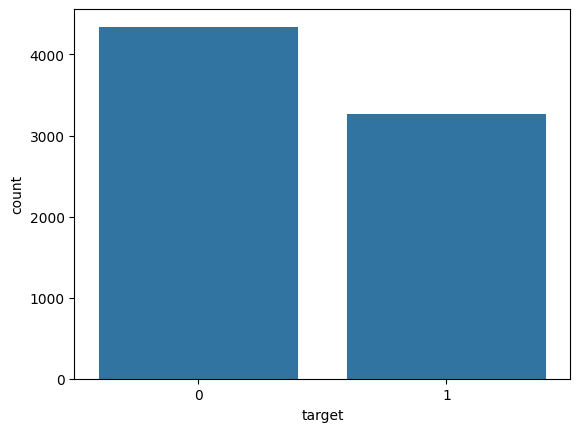

In [11]:
sns.countplot(x='target', data=df_train)
plt.show()

In [12]:
print("contoh tweet bukan tentang bencana:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['text'].values[i]}")

print("\ncontoh tweet tentang bencana:")
for i in range(5):
    print(f"{i}. {df_train[df_train['target'] == 1].sample(10)['text'].values[i]}")

contoh tweet bukan tentang bencana:
1. @UABStephenLong @courtlizcamp Total tweet fail! You are so beautiful inside and out Blaze On!
2. Shark boy and lava girl for the third time today. I guess this is what having kids feelings like. ??????
3. Speaking of memorable debates: 60-Second Know-It-All: Ronald Reagan's landslide romp on Election Day in 1980 m... http://t.co/2XOhtjQJWh
4. My brains going to explode i need to leave this house. Ill be out smoking packs if you need me
5. YOUR PHONE IS SPYING ON YOU! Hidden Back Door NSA Data Mining Software | THE FINANCIAL ARMAGEDDON BLOG http://t.co/qyCw5JJaj1

contoh tweet tentang bencana:
0. Forest fire near La Ronge Sask. Canada
1. 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/iTBJ6DKRZI
2. The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr
3. Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/h6Z7hXUqtu v

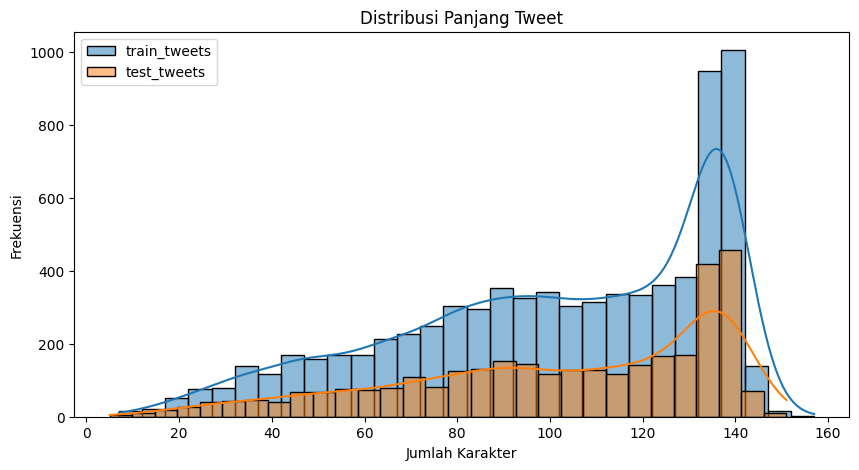

In [13]:
# Plot distribusi panjang tweet
plt.figure(figsize=(10, 5))
sns.histplot(df_train['text'].apply(len), bins=30, kde=True, label="train_tweets")
sns.histplot(df_test['text'].apply(len), bins=30, kde=True, label="test_tweets")
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

In [14]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

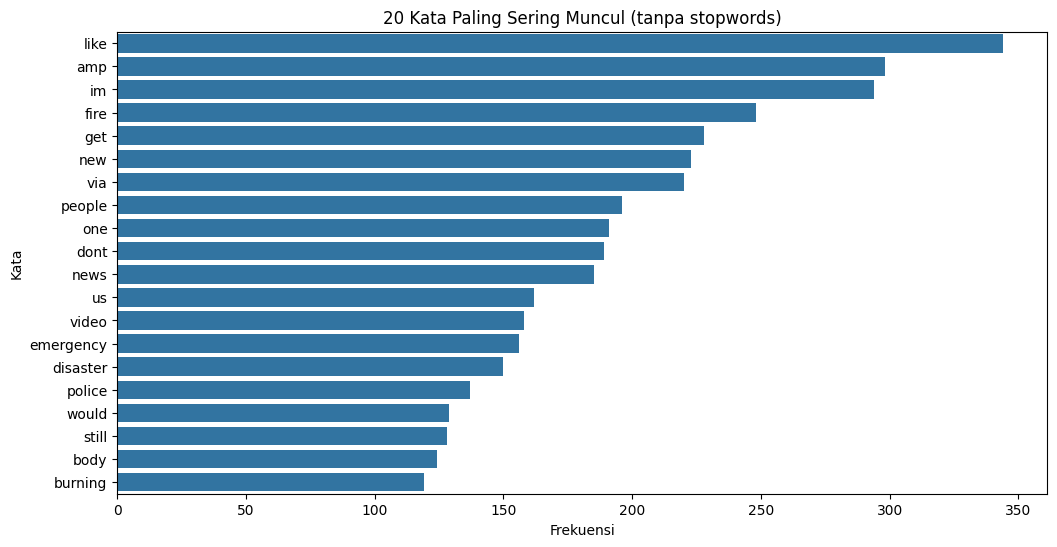

In [15]:
stop_words = set(stopwords.words('english'))
all_words = []

for text in df_train['text']:
    words = clean_text(text).split()
    words = [word for word in words if word not in stop_words]
    all_words.extend(words)

# Ambil 20 kata paling sering
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(freqs), y=list(words))
plt.title('20 Kata Paling Sering Muncul (tanpa stopwords)')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

## Data Preprocessing

In [16]:
# cleaning the text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and train datasets
df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['text'].apply(lambda x: clean_text(x))

# updated text
print("contoh tweet bukan tentang bencana yang sudah dibersihkan:")
for i in range(5):
    print(f"{i+1}. {df_train[df_train['target'] == 0].sample(10)['clean_text'].values[i]}")


contoh tweet bukan tentang bencana yang sudah dibersihkan:
1. dont like those head first slides especially into home  danger
2. a look at state actions a year after fergusonûªs upheaval  
3. tornadogiveaway åê thebookclub åê join in  
4. new explosionproof tempered glass screen protector film for blackberry   full read byû  
5.  yes god doessnt change  he says not to rejoice over the fall of people or calamities like wild fires  ect  you wanna be punished


In [17]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenator(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words] # Stopword removal + lemmatizing
    # tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]  # Stopword removal + stemming
    tokens = " ".join(tokens)
    return tokens


df_train['tokenize_text'] = df_train['clean_text'].apply(tokenator)

In [18]:
df_train.sample(10)

,id,text,target,clean_text,tokenize_text
3404,4874,See these guys reaching the front foot out loa...,0,see these guys reaching the front foot out loa...,see guy reaching front foot loading shoulder s...
385,558,Los Angeles Times: Arson suspect linked to 30 ...,1,los angeles times arson suspect linked to fir...,los angeles time arson suspect linked fire cau...
4967,7078,Ever since my Facebook #Mets meltdown after th...,0,ever since my facebook mets meltdown after the...,ever since facebook mets meltdown padre fiasco...
5953,8504,@camilacabello97 NOW IM INTERNALLY SCREAMING,0,now im internally screaming,im internally screaming
4753,6762,Expect gusty winds heavy downpours and lightni...,1,expect gusty winds heavy downpours and lightni...,expect gusty wind heavy downpour lightning mov...
1228,1769,Watching Xela firefighters struggle to save bu...,1,watching xela firefighters struggle to save bu...,watching xela firefighter struggle save burnin...
7142,10234,@songhey89 well I'm also gay but girls like so...,0,well im also gay but girls like some too so ...,well im also gay girl like predict tsunami amp...
1038,1504,@baskgod body bags,0,baskgod body bags,baskgod body bag
6301,9002,@Stretcher @Rexyy @invalid @Towel let's have b...,0,stretcher rexyy invalid towel lets have babies,stretcher rexyy invalid towel let baby
6836,9791,@BoyInAHorsemask its a panda trapped in a dogs...,1,boyinahorsemask its a panda trapped in a dogs ...,boyinahorsemask panda trapped dog body


## Text Vectorization

In [19]:
# Inisialisasi vectorizer
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)

# Fit dan transform teks
X_count = count_vectorizer.fit_transform(df_train['tokenize_text'])
X_tfidf = tfidf_vectorizer.fit_transform(df_train['tokenize_text'])

# Label
y = df_train['target']

print("Shape CountVectorizer:", X_count.shape)
print("Shape TFIDFVectorizer:", X_tfidf.shape)

Shape CountVectorizer: (7613, 15200)
Shape TFIDFVectorizer: (7613, 10000)


## Feature Selection

In [20]:
selector = SelectKBest(chi2, k=3000)
X_selected = selector.fit_transform(X_tfidf, y)

# Label
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=12, stratify=y)

## Training & Evaluation Models

In [21]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [22]:
y_pred_nb = nb_model.predict(X_test)

# print("\n=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))
# print(confusion_matrix(y_test, _nb_lr))
print("Akurasi:", accuracy_score(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       869
           1       0.91      0.67      0.77       654

    accuracy                           0.83      1523
   macro avg       0.85      0.81      0.82      1523
weighted avg       0.84      0.83      0.82      1523

Akurasi: 0.8273145108338805


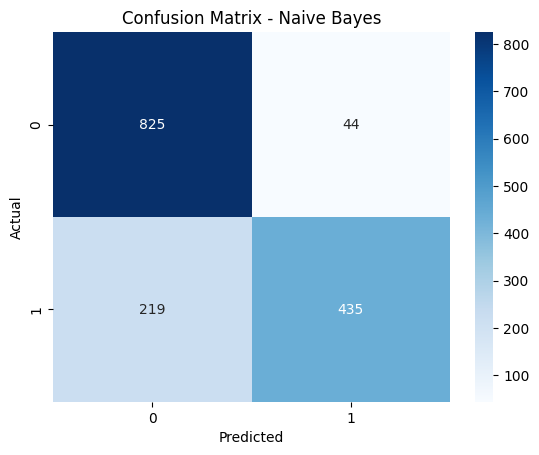

In [23]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_test, y_pred_nb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")

### Tuning

Grid Search

In [24]:
# Parameter grid
param_grid = [
    {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True],
        'class_prior': [[0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]
    },
    {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [False]
        # Saat fit_prior=False, class_prior tidak digunakan (harus None)
    }
]


# Gunakan GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit model ke data latih
grid_search.fit(X_train, y_train)

# Cetak hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Uji model terbaik pada data test
best_nb = grid_search.best_estimator_
y_pred = best_nb.predict(X_test)

print("\n=== Naive Bayes (After Tuning) ===")
print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Best parameters: {'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': True}
Best cross-validation accuracy: 0.8435139573070607

=== Naive Bayes (After Tuning) ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       869
           1       0.86      0.81      0.83       654

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.86      1523
weighted avg       0.86      0.86      0.86      1523

Test Accuracy: 0.8594878529218647


### Model dengan Parameter Terbaik

In [25]:
# Buat model baru dengan parameter terbaik
best_params = {
    'alpha': 0.01,
    'fit_prior': True,
    'class_prior': [0.5, 0.5]
}

final_model = MultinomialNB(**best_params)

# Latih model pada data latih
final_model.fit(X_train, y_train)

# Evaluasi model pada data uji
y_pred_final = final_model.predict(X_test)

print("\n=== Final Naive Bayes Model ===")
print(classification_report(y_test, y_pred_final))
print("Test Accuracy:", accuracy_score(y_test, y_pred_final))


=== Final Naive Bayes Model ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       869
           1       0.86      0.81      0.83       654

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.86      1523
weighted avg       0.86      0.86      0.86      1523

Test Accuracy: 0.8594878529218647


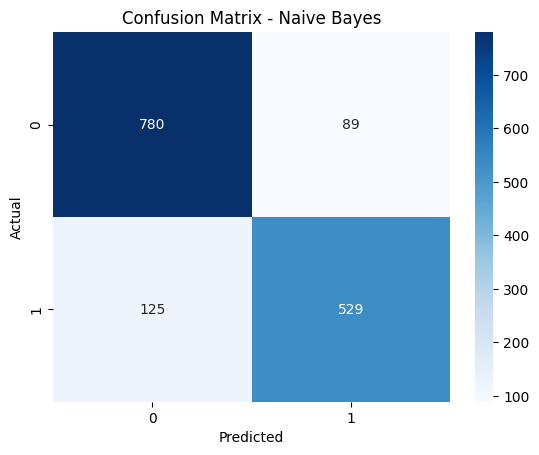

In [37]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_test, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")

## Cross Validation

In [26]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Model terbaik dari tuning
final_model = MultinomialNB(**best_params)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
scoring = ['accuracy', 'precision', 'recall', 'f1']

cv_results = cross_validate(final_model, X_selected, y, cv=cv, scoring=scoring)

# Tampilkan hasil
print("\n=== Cross-Validation on Final Model ===")
for metric in scoring:
    mean = cv_results[f'test_{metric}'].mean()
    std = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean:.4f} (+/- {std:.4f})")


=== Cross-Validation on Final Model ===
ACCURACY: 0.8512 (+/- 0.0071)
PRECISION: 0.8629 (+/- 0.0103)
RECALL: 0.7771 (+/- 0.0125)
F1: 0.8177 (+/- 0.0092)


## Analisis Error & Prediksi Salah

In [27]:
df_val = df_train.copy()

# Transformasi ke TF-IDF dan feature selection
X_tfidf = tfidf_vectorizer.transform(df_val['tokenize_text'])
X_selected = selector.transform(X_tfidf)

# Prediksi Naive Bayes
df_val['predicted'] = best_nb.predict(X_selected)

# Ambil prediksi salah
df_val = df_val[['text', 'target', 'predicted']]
df_val = df_val[df_val['target'] != df_val['predicted']]

# Salah prediksi kategori
df_val_real = df_val[df_val['target'] == 1]  # False Negative
df_val_fake = df_val[df_val['target'] == 0]  # False Positive

### False Negatives (seharusnya bencana, diprediksi bukan)

In [29]:
print("False Negatives (seharusnya bencana, diprediksi bukan):")
df_val_real

False Negatives (seharusnya bencana, diprediksi bukan):


,text,target,predicted
7,I'm on top of the hill and I can see a fire in...,1,0
11,Haha South Tampa is getting flooded hah- WAIT ...,1,0
12,#raining #flooding #Florida #TampaBay #Tampa 1...,1,0
81,I was in a horrible car accident this past Sun...,1,0
99,only had a car for not even a week and got in ...,1,0
...,...,...,...
7491,Wreck with road blockage Woodward Avenue North...,1,0
7500,Omg if Cain dies i will be an emotional wreck ...,1,0
7552,Israel wrecked my home. Now it wants my land. ...,1,0
7572,@Kirafrog @mount_wario Did you get wrecked again?,1,0


In [32]:
for i in range(50, 55):
    print(f"Tweet: {df_val_real['text'].iloc[i]}")
    print(f"Target: 1 (bencana), Predicted: 0 (bukan bencana)")
    print("-" * 50)

Tweet: I waited 2.5 hours to get a cab my feet are bleeding
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @KatRamsland Yes I'm a bleeding heart liberal.
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @beckyfeigin I defs will when it stops bleeding!
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @Benjm1 @TourofUtah @B1Grego saw that pileup on TV keep racing even bleeding
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @BenKin97 @Mili_5499 remember when u were up like 4-0 and blew it in one game? U probs don't because it was before the kings won the cup
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------


### False Positives (seharusnya bukan bencana, diprediksi bencana)

In [31]:
print("False Positives (seharusnya bukan bencana, diprediksi bencana):")
df_val_fake

False Positives (seharusnya bukan bencana, diprediksi bencana):


,text,target,predicted
18,My car is so fast,0,1
71,#stlouis #caraccidentlawyer Speeding Among Top...,0,1
90,???? it was an accident http://t.co/Oia5fxi4gM,0,1
96,Has an accident changed your life? We will hel...,0,1
98,@flowri were you marinading it or was it an ac...,0,1
...,...,...,...
7383,I like the weird ones like Rain of Mystical or...,0,1
7412,Have you ever seen the President \nwho killed ...,0,1
7442,RT @DianneG: Gunshot wound #9 is in the bicep....,0,1
7456,I keep scrolling to find out what he said or d...,0,1


In [36]:
for i in range(50, 55):
    print(f"Tweet: {df_val_fake['text'].iloc[i]}")
    print(f"Target: 1 (bencana), Predicted: 0 (bukan bencana)")
    print("-" * 50)

Tweet: @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: @RockBottomRadFM Is one of the challenges on Tough Enough rescuing people from burning buildings?
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: So my band Buildings on Fire are playing @bbcintroducing @PurpleTurtleRdg this Wednesday with @GIANTGIANTSOUND https://t.co/ofaN6DkOEZ #rdg
Target: 1 (bencana), Predicted: 0 (bukan bencana)
--------------------------------------------------
Tweet: burned 202 calories doing 30 minutes of Walking 4.0 mph very brisk pace #myfitnesspal
Target: 1 (bencana), Predicted: 0 (bukan bencana)
----------------